<a href="https://colab.research.google.com/github/evanzzell08/NLP/blob/main/Mountains_NER_RoBERTa_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install transformers[torch]
!pip install datasets
! pip install seqeval
! pip install -U transformers

In [ ]:
# imports
from transformers import RobertaTokenizer, RobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer
from datasets import load_dataset, Dataset
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Ready Dataset Prep

In [5]:
train_dataset = load_dataset("telord/mountains-ner-dataset", split="train")
valid_dataset = load_dataset("telord/mountains-ner-dataset", split="val")
test_dataset  = load_dataset("telord/mountains-ner-dataset", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/578 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/811k [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/106k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/109k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3827 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/478 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/479 [00:00<?, ? examples/s]

In [5]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3827
Validation dataset size: 478
Test dataset size: 479


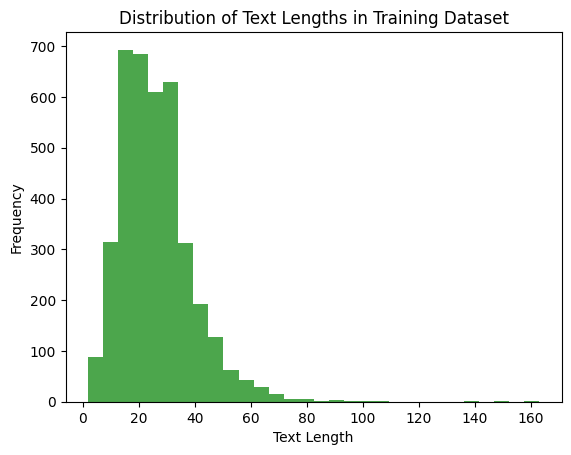

In [6]:
# calculating text lengths
text_lengths = [len(example['tokens']) for example in train_dataset]

# plotting the distribution
plt.hist(text_lengths, bins=30, alpha=0.7, color='green')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths in Training Dataset")
plt.show()

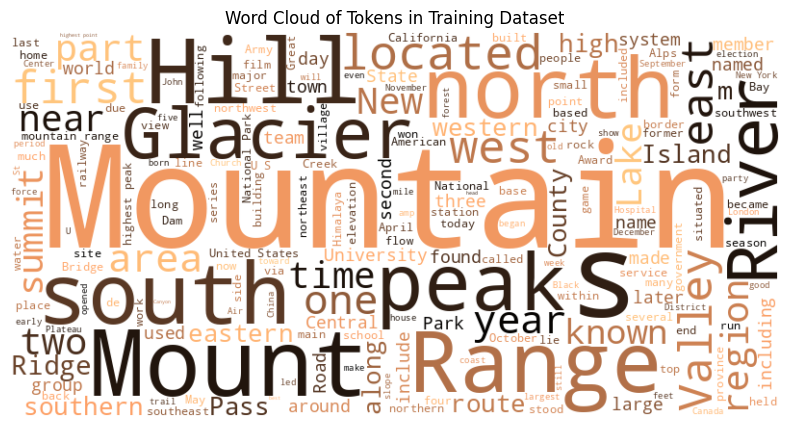

In [7]:
# generating a word cloud for tokens
all_tokens = [token for example in train_dataset for token in example['tokens']]
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(all_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tokens in Training Dataset")
plt.show()


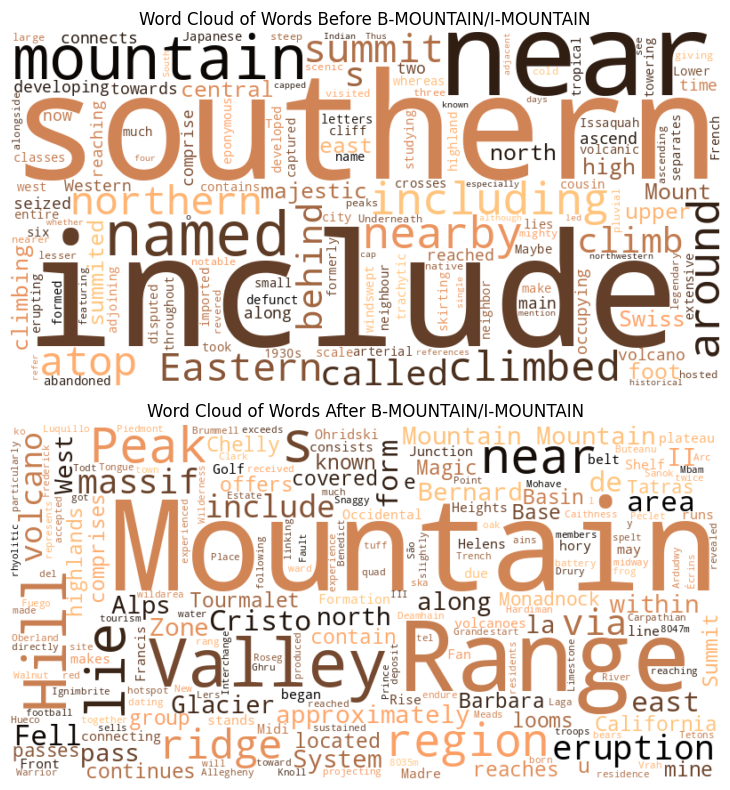

In [8]:
# lists of words preceeding or standing after tokens labeled B-MOUNTAIN/I-MOUNTAIN
words_before = []
words_after = []

# iretating through the dataset
for example in train_dataset:
    tokens = example['tokens']
    labels = example['labels']
    for i, label in enumerate(labels):
        if label==1:
            # a word before B-MOUNTAIN
            if i > 0:
                words_before.append(tokens[i - 1])
            # a word after B-MOUNTAIN and not I-MOUNTAIN
            if i < len(tokens) - 1 and labels[i+1]!=2:
                words_after.append(tokens[i + 1])
            # a word after a B-MOUNTAIN and I-MOUNTAIN pair
            elif i < len(tokens) - 1 and labels[i+1]==2:
                words_after.append(tokens[i + 2])

# generating a Word Cloud for words preceeding mountains
wordcloud_before = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(words_before))

# generating a Word Cloud for words after mountains
wordcloud_after = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(words_after))

# plotting the Word Clouds
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Words Before B-MOUNTAIN/I-MOUNTAIN")

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_after, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Words After B-MOUNTAIN/I-MOUNTAIN")

plt.tight_layout()
plt.show()


In [9]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

def convert_to_features(batch):
    # tokenization for tokens of each sent in batch
    encoding = tokenizer(batch['tokens'], truncation=True, padding='longest', is_split_into_words=True)

    # labels to indexes (for the custom dataset)
    # label_map = {'O': 0, 'B-MOUNTAIN': 1, 'I-MOUNTAIN': 2}

    # processing labels for each sentence in batch
    all_labels = batch['labels']
    label_ids_batch = []
    for labels in all_labels:
        # label_ids = [label_map[label] for label in labels]
        label_ids = [label for label in labels]
        label_ids_batch.append(label_ids)

    # aligning labels to their ids
    encoding['labels'] = label_ids_batch
    return encoding

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
# applying the tokenizer to the dataset
train_dataset = train_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                  batched=True)
valid_dataset = valid_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                  batched=True)
test_dataset = test_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                batched=True)

Map:   0%|          | 0/3827 [00:00<?, ? examples/s]

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

In [11]:
train_dataset.column_names

['labels', 'input_ids', 'attention_mask']

In [ ]:
train_dataset[0]

### Custom Dataset Prep

In [ ]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="/content/fixed_mountains_dataset.json", field='data', split="train")

print(dataset[-1])

Generating train split: 0 examples [00:00, ? examples/s]

{'sentence_id': 85, 'tokens': ['Manāslu', 'I', 'is', 'the', 'eighth', 'highest', 'mountain', 'in', 'the', 'world', '.', 'It', 'is', 'known', 'for', 'its', 'technical', 'climbs'], 'labels': ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


In [ ]:
invalid_sentences = []

for item in dataset:
    tokens = item['tokens']
    labels = item['labels']

    # checking tokens and labels consistency
    if len(tokens) != len(labels):
        invalid_sentences.append(item['sentence_id'])

if invalid_sentences:
    print(invalid_sentences)

In [ ]:
# applying tokenization
dataset = dataset.map(convert_to_features,
                      remove_columns=["tokens", "labels"],
                      batched=True)

# splitting to train and test
data_splitted = dataset.train_test_split(test_size=0.15)
train0_dataset = data_splitted['train']
test_dataset = data_splitted['test']

# further splitting to train and val
train_splitted = train0_dataset.train_test_split(test_size=0.1)
train_dataset = train_splitted['train']
val_dataset = train_splitted['test']


#### Sense-for-sense translation Data Augmentation (not sufficient)

Augmenting the data using [sense-for-sense translation](https://www.fiive.se/en/blog/backtranslation-for-ner) and changing some of the mountain names with other mountains.

In [ ]:
!pip install googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=6ce9acac2935ba9a4f5d1fa8f2594b39b53b99a65176196ad5737494169a7186
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Suc

In [ ]:
from googletrans import Translator
import re
import random

In [ ]:
def mask_entities(tokens, labels):
    masked_tokens = []
    mask_mapping = {}  # Map to store original tokens with their masks

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label != 'O':  # Mask only named entities
            mask = f"X-{random.randint(1000, 9999)}"
            masked_tokens.append(mask)
            mask_mapping[mask] = token  # Save the original token with its mask
        else:
            masked_tokens.append(token)

    return masked_tokens, mask_mapping

# Function to reinsert original tokens into the translated text
def reinsert_original_tokens(translated_text, mask_mapping):
    translated_tokens = translated_text.split()  # Split translated text into tokens

    for mask, original_token in mask_mapping.items():
        # Replace the mask in the translated sentence with the original token
        translated_tokens = [original_token if token == mask else token for token in translated_tokens]

    return ' '.join(translated_tokens)

In [ ]:
def translate_with_masks(tokens, src_lang, dest_lang):
    # Join the tokens to form the sentence
    sentence_text = ' '.join(tokens)
    # Translate the sentence with masked tokens
    translated_text = translator.translate(sentence_text, src=src_lang, dest=dest_lang).text  # Translate to Spanish as an example
    print("Translated with masks: ", translated_text)
    return translated_text

In [ ]:
def translate_masked_tokens(masked_tokens, masked_indices):
    # translator = Translator()
    translated_tokens = masked_tokens.copy()  # Make a copy to replace the masked tokens

    for i in masked_indices:
        # Translate each masked token separately
        original_token = masked_tokens[i]
        translated_token = translator.translate(original_token, src='en', dest='uk').text
        translated_tokens[i] = translated_token  # Replace the masked token with the translated token

    return translated_tokens

In [ ]:
def sense_for_sense_translation(data):
    for sentence_data in data:
        tokens = sentence_data['tokens']
        labels = sentence_data['labels']

        # masking the entities
        masked_tokens, mask_mapping = mask_entities(tokens, labels)

        # translating the sentence with masked tokens several times
        translated_text = translate_with_masks(masked_tokens, 'en', 'uk')
        translated_text = translate_with_masks(translated_text.split(), 'uk', 'ja')
        translated_text = translate_with_masks(translated_text.split(), 'ja', 'it')
        back_translated_text = translate_with_masks(translated_text.split(), 'it', 'en')

        # reinserting original tokens into the back-translated sentence
        final_translated_sentence = reinsert_original_tokens(back_translated_text, mask_mapping)

        # displaying the results
        print("Original sentence:", ' '.join(tokens))
        print("Masked sentence:", ' '.join(masked_tokens))
        # print("Translated sentence with masks:", translated_text)
        print("Back-translated sentence:", back_translated_text)
        print("Final translated sentence after reinsertion:", final_translated_sentence)
        print()

In [ ]:
# initializing the Google Translator
translator = Translator()
sense_for_sense_translation(dataset)

Translated with masks:  X-7592 X-5948-це найвища гора на Землі.
Translated with masks:  X-7592 X-5948は、地球上で最も高い山です。
Translated with masks:  X-7592 X-5948 è la montagna più alta della terra.
Translated with masks:  X-7592 X-5948 is the highest mountain on Earth.
Original sentence: Mount Everest is the highest mountain on Earth .
Masked sentence: X-7592 X-5948 is the highest mountain on Earth .
Back-translated sentence: X-7592 X-5948 is the highest mountain on Earth.
Final translated sentence after reinsertion: Mount Everest is the highest mountain on Earth.

Translated with masks:  Незважаючи на свою висоту, X-5822 X-2400 представляє складний підйом.
Translated with masks:  その高さにもかかわらず、X-5822 X-2400は困難な隆起です。
Translated with masks:  Nonostante la sua altezza, l'X-5822 X-2400 è un sollevamento difficile.
Translated with masks:  Despite its height, the X-5822 X-2400 is a difficult lifting.
Original sentence: Despite its altitude , Mount Everest presents a challenging climb .
Masked sentenc

KeyboardInterrupt: 

### Weighting Classes

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# weighting the classes
class_weights = compute_class_weight('balanced', classes=np.unique([0, 1, 2]), y=np.concatenate(train_dataset[:]['labels']))  # 0 = 'O', 1 = 'B-MOUNTAIN', 2 = 'I-MOUNTAIN'
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(class_weights)

tensor([ 0.3528, 11.9007, 12.3141])


## RoBERTa

### Training

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    label_list = ['O', 'B-MOUNTAIN', 'I-MOUNTAIN']
    true_labels = [
        [label_list[label] for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [label_list[pred] for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    # report = classification_report(true_labels, pred_labels)
    # print(report)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)
# model = AutoModelForTokenClassification.from_pretrained("botryan96/GeoBERT", from_tf=True, num_labels=3)
model = RobertaForTokenClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)
model.to(device)

# defining training params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy = 'epoch',
    # eval_steps=100,
    logging_dir='./logs',
    logging_steps=100,
    logging_strategy="steps",
    # save_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    dataloader_num_workers=4,
    save_total_limit=2,
    warmup_ratio=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="recall",
    greater_is_better=True,
    fp16 = True,
    # learning_rate = 1e-04,
    weight_decay = 0.01
)

# early stopping params
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.001
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


input_ids
attention_mask
labels


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeva-velychko (yeva-velychko-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.163300,0.175189,0.369792,0.208824,0.266917
2,0.130200,0.129619,0.457447,0.252941,0.325758
3,0.098600,0.114937,0.510549,0.355882,0.419411
4,0.091600,0.144769,0.425197,0.317647,0.363636
5,0.078500,0.111113,0.560484,0.408824,0.472789
6,0.066000,0.118657,0.465190,0.432353,0.448171
7,0.064900,0.136124,0.578947,0.420588,0.487223
8,0.055500,0.154247,0.511401,0.461765,0.485317
9,0.035900,0.147836,0.560137,0.479412,0.516640
10,0.034000,0.173320,0.550000,0.452941,0.496774


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

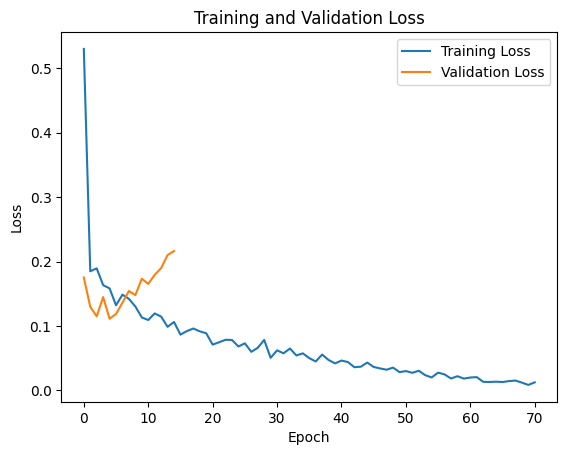

In [15]:
from transformers import DataCollatorForTokenClassification
import torch.nn as nn

data_collator = DataCollatorForTokenClassification(tokenizer)
for batch in data_collator(train_dataset):
    print(batch)

class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        # using class weights for the loss
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, labels):
        return self.loss_fn(logits, labels)

# setting the weighted loss
model.loss_fn = WeightedCrossEntropyLoss(class_weights)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

train_result = trainer.train()

trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

# loss visualization
train_loss = trainer.state.log_history
train_losses = [entry['loss'] for entry in train_loss if 'loss' in entry]
# print(len(train_losses))
eval_losses = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]
# print(len(eval_losses))

plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [16]:
print(trainer.state.log_history)

[{'loss': 0.5301, 'grad_norm': 3.304800033569336, 'learning_rate': 1.3472222222222222e-05, 'epoch': 0.20876826722338204, 'step': 100}, {'loss': 0.1849, 'grad_norm': 4.354894161224365, 'learning_rate': 2.7361111111111114e-05, 'epoch': 0.4175365344467641, 'step': 200}, {'loss': 0.1894, 'grad_norm': 3.2159276008605957, 'learning_rate': 4.125e-05, 'epoch': 0.6263048016701461, 'step': 300}, {'loss': 0.1633, 'grad_norm': 1.7931073904037476, 'learning_rate': 4.972893772893773e-05, 'epoch': 0.8350730688935282, 'step': 400}, {'eval_loss': 0.1751890331506729, 'eval_precision': 0.3697916666666667, 'eval_recall': 0.2088235294117647, 'eval_f1': 0.2669172932330827, 'eval_runtime': 1.5433, 'eval_samples_per_second': 309.717, 'eval_steps_per_second': 38.877, 'epoch': 1.0, 'step': 479}, {'loss': 0.1583, 'grad_norm': 1.9095449447631836, 'learning_rate': 4.8996336996337e-05, 'epoch': 1.0438413361169103, 'step': 500}, {'loss': 0.132, 'grad_norm': 0.8473513126373291, 'learning_rate': 4.8263736263736266e-05

In [17]:
best_metric = trainer.state.best_metric
best_checkpoint = trainer.state.best_model_checkpoint

print(f"Best Metric: {best_metric}")
print(f"Best Model Checkpoint: {best_checkpoint}")

best_epoch_log = next(
    (log for log in trainer.state.log_history if log.get("eval_loss") == best_metric),
    None
)

if best_epoch_log:
    print("Detailed Best Epoch Results:")
    for key, value in best_epoch_log.items():
        print(f"{key}: {value}")
else:
    print("No detailed log found for the best metric.")


Best Metric: 0.5176470588235295
Best Model Checkpoint: ./results/checkpoint-6227
No detailed log found for the best metric.


In [18]:
from transformers import Trainer, TrainingArguments

# testing params
test_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

tester = Trainer(
    model=model,
    args=test_args,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = tester.evaluate(test_dataset)
print(results)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 0.20708677172660828, 'eval_model_preparation_time': 0.0031, 'eval_precision': 0.49876543209876545, 'eval_recall': 0.5343915343915344, 'eval_f1': 0.5159642401021712, 'eval_runtime': 1.1003, 'eval_samples_per_second': 435.329, 'eval_steps_per_second': 27.265}


### Testing

In [19]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

flat_pred_labels = []
flat_true_labels = []

for i in range(len(pred_labels)):
    pred_label = pred_labels[i][true_labels[i] != -100]
    true_label = true_labels[i][true_labels[i] != -100]

    flat_pred_labels.extend(pred_label)
    flat_true_labels.extend(true_label)

print("Flat Pred:")
print(flat_pred_labels)
print("Flat True:")
print(flat_true_labels)

report = classification_report(flat_true_labels, flat_pred_labels, target_names=["O", "B-MOUNTAIN", "I-MOUNTAIN"])
print(report)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Flat Pred:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [30]:
sentence = "The Alps (/ælps/)[a] are one of the highest and most extensive mountain ranges in Europe,[b][2] stretching approximately 1,200 km (750 mi) across eight Alpine countries (from west to east): Monaco, France, Switzerland, Italy, Liechtenstein, Germany, Austria and Slovenia.[c][4]"
sentence = [
                "We",
                "climbed",
                "on",
                "Everest",
                # "is",
                # "the",
                # "highest",
                "mountain",
                # "on",
                # "Earth",
                "."
            ]
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
inputs = inputs.to(device)

# predicting
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

token_ids = inputs["input_ids"][0].tolist()
tokens = tokenizer.convert_ids_to_tokens(token_ids)
pred_labels = predictions[0].tolist()

label_map = {0: 'O', 1: 'B-MOUNTAIN', 2: 'I-MOUNTAIN'}

predicted_labels = [label_map[label] for label in pred_labels]  # labels to strings

for idx, (token, label) in enumerate(zip(tokens, predicted_labels)):
  print(f"Token ID: {token_ids[idx]} - Token: {token} - Label: {label}")

mountain_name = []
for token, label in zip(tokens, predicted_labels):
    if label == 'B-MOUNTAIN' or label == 'I-MOUNTAIN':
            mountain_name.append(token)

# getting the mountains names
mountain_name = tokenizer.convert_tokens_to_string(mountain_name)

print("Mountain Name:", mountain_name)


Token ID: 0 - Token: <s> - Label: O
Token ID: 166 - Token: ĠWe - Label: O
Token ID: 7334 - Token: Ġclimbed - Label: O
Token ID: 15 - Token: Ġon - Label: B-MOUNTAIN
Token ID: 26819 - Token: ĠEverest - Label: I-MOUNTAIN
Token ID: 726 - Token: ĠAl - Label: O
Token ID: 29270 - Token: pes - Label: O
Token ID: 6485 - Token: Ġmountain - Label: O
Token ID: 479 - Token: Ġ. - Label: O
Token ID: 2 - Token: </s> - Label: O
Mountain Name:  on Everest


## SVM

In [6]:
import spacy
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# from datasets import load_dataset
import numpy as np
import re
from sklearn.model_selection import GridSearchCV

### Helper Functions

In [7]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # removing HTML tags
    text = re.sub(r'[^\w\s.,!?]', '', text)  # removing special characters
    text = re.sub(r'\s+', ' ', text).strip()  # removing extra spaces
    return text

In [8]:
nlp = spacy.load("en_core_web_sm")

def extract_features(tokens, idx):
    token = tokens[idx]
    features = {
        "word": token.text,
        "is_title": token.text.istitle(),
        "is_digit": token.text.isdigit(),
        "is_alpha": token.is_alpha,
        "is_stop": token.is_stop,
        "prev_word": tokens[idx-1].text if idx > 0 else "<START>",
        "next_word": tokens[idx+1].text if idx < len(tokens)-1 else "<END>",
        "pos_tag": token.pos_,
        "dep_tag": token.dep_
    }
    return features

In [9]:
def prepare_data(dataset):
    X = []
    y = []

    for example in dataset:
        sentence = clean_text(example["sentence"])
        tokens = nlp(sentence)
        # tokens = [token for token in tokens if not token.is_punct]

        labels = example["labels"]

        # aligning labels and tokens
        aligned_labels = []
        label_idx = 0

        for token in tokens:
            if label_idx < len(labels) and labels[label_idx] in [1, 2]:
              aligned_labels.append(labels[label_idx])  # exact token match
              label_idx += 1
            else:
              aligned_labels.append(0)  # adding a label for new tokens

        if len(tokens) != len(aligned_labels):
            print(f"Warning: Token count ({len(tokens)}) doesn't match label count ({len(aligned_labels)}) for sentence: {sentence}")
            continue

        for idx in range(len(tokens)):
            features = extract_features(tokens, idx)
            X.append(features)
            y.append(aligned_labels[idx])

    return X, y

### EDA

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# extracting features for the words
X_train, y_train = prepare_data(train_dataset)
X_valid, y_valid = prepare_data(valid_dataset)
X_test, y_test = prepare_data(test_dataset)

In [27]:
len(X_train), len(y_train)

(97505, 97505)

In [28]:
X_train[0]

{'word': 'Virender',
 'is_title': True,
 'is_digit': False,
 'is_alpha': True,
 'is_stop': False,
 'prev_word': '<START>',
 'next_word': 'Sehwag',
 'pos_tag': 'PROPN',
 'dep_tag': 'compound'}

In [12]:
set(y_train)

{0, 1, 2}

In [12]:
def modify_labels(word_list, X_train, y_train, X_valid, y_valid, X_test, y_test):
    # iterating over the datasets and updating labels if the word is in the given list
    for X, y in [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]:
        for i, row in enumerate(X):
          if row['word'] in word_list:
              y[i] = 0  # setting label to 0 if the word is in the list

    return y_train, y_valid, y_test

y_train, y_valid, y_test = modify_labels(['Mount', 'Mountain', 'Mountains', 'Peak', 'The', 'Hill'], X_train, y_train, X_valid, y_valid, X_test, y_test)

Many general words (like Mountain, Peak, The, Hill) were labeled as mountain names in the original dataset, so we correct it via *modify_labels* function.

Previous mountain names distribution:
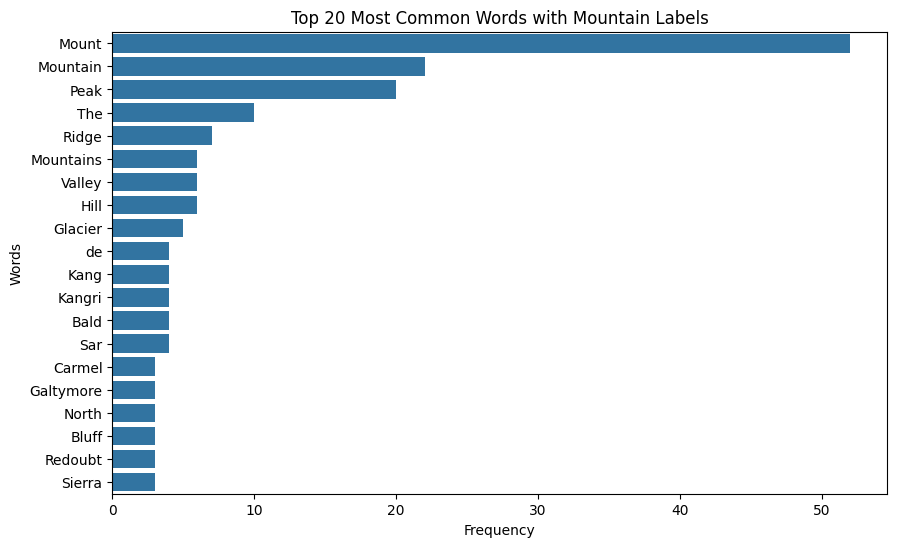

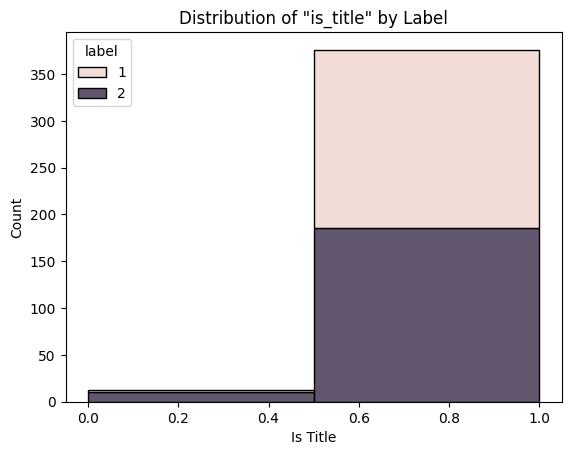

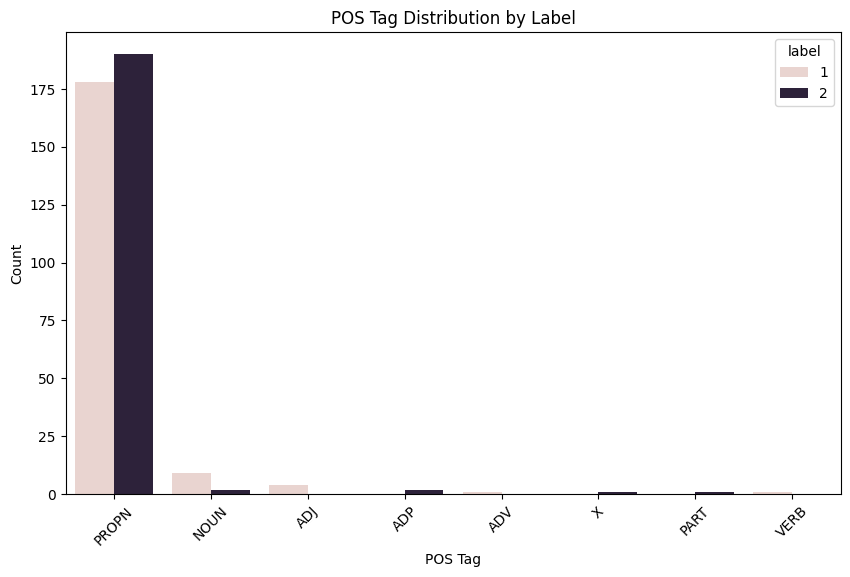

In [14]:
mountains = [
    {**X_train[i], "label": y_train[i]} for i in range(len(y_train)) if y_train[i] in [1, 2]
]

df = pd.DataFrame(mountains)

sns.histplot(data=df, x='is_title', hue='label', multiple='stack', bins=2)
plt.title('Distribution of "is_title" by Label')
plt.xlabel('Is Title')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='pos_tag', hue='label', order=df['pos_tag'].value_counts().index)
plt.title('POS Tag Distribution by Label')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [15]:
df.head()

,word,is_title,is_digit,is_alpha,is_stop,prev_word,next_word,pos_tag,dep_tag,label
0,Nangtud,True,False,True,False,Mount,is,PROPN,nsubj,2
1,Jotunheimen,True,False,True,False,<START>,is,NOUN,nsubj,1
2,Dolores,True,False,True,False,<START>,Heights,PROPN,compound,1
3,Heights,True,False,True,False,Dolores,is,PROPN,nsubj,2
4,Aiguille,True,False,True,False,<START>,de,PROPN,nmod,1


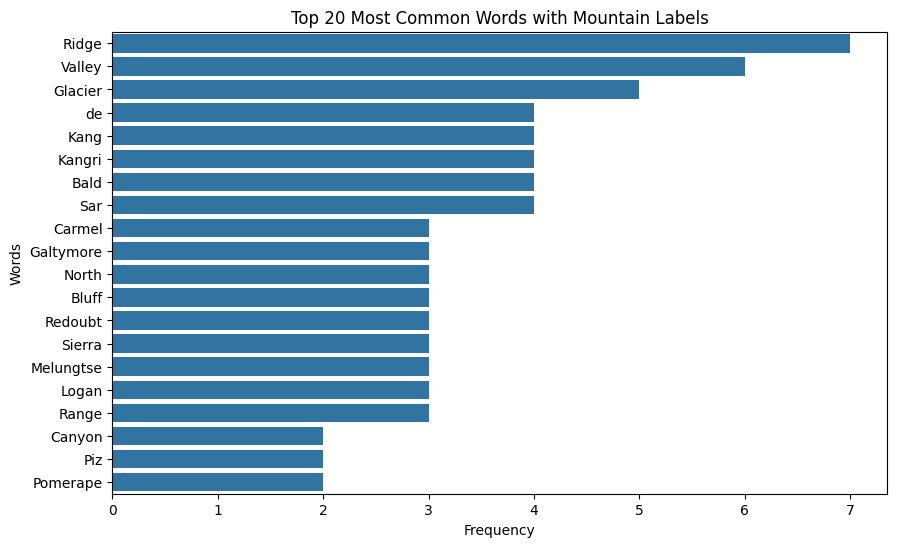

In [16]:
from collections import Counter

word_counts = Counter(df['word'])
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words)
plt.title('Top 20 Most Common Words with Mountain Labels')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


Correlation with the label:
label        1.000000
is_title     0.099014
pos_tag      0.047176
is_alpha     0.019562
dep_tag     -0.003868
is_digit    -0.008501
next_word   -0.019453
is_stop     -0.045518
word        -0.048492
prev_word   -0.062636
Name: label, dtype: float64


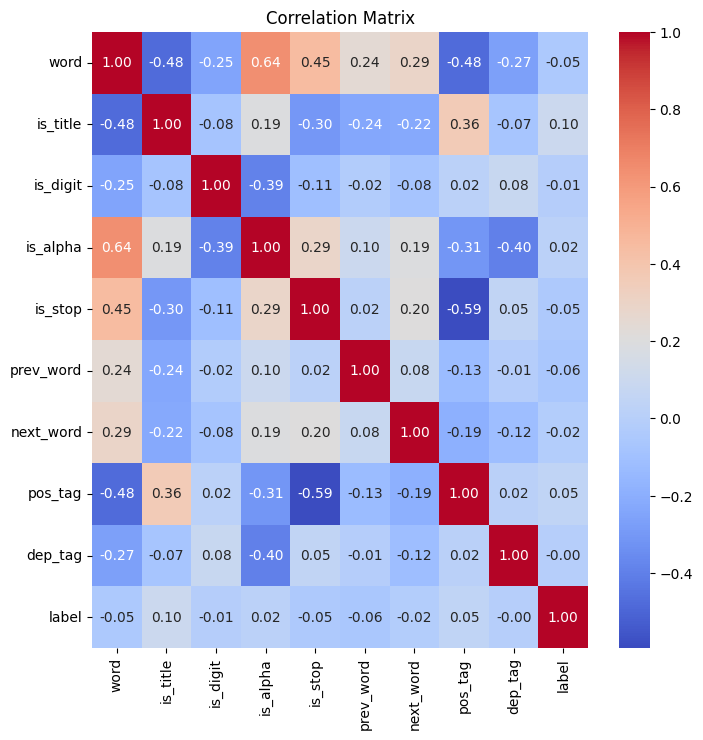

In [17]:
from sklearn.preprocessing import LabelEncoder

full_data = [
    {**X_train[i], "label": y_train[i]} for i in range(len(y_train))
]

df_numeric = pd.DataFrame(full_data)

# encoding categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns

for feature in categorical_features:
    encoder = LabelEncoder()
    df_numeric[feature] = encoder.fit_transform(df_numeric[feature])

# calculating the correlations
correlation_matrix = df_numeric.corr()
label_correlations = correlation_matrix['label'].sort_values(ascending=False)

print("Correlation with the label:")
print(label_correlations)

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [29]:
# function to filter the uncorrelated features
def filter_features(dataset, selected_features):
    return [
        {key: value for key, value in features.items() if key in selected_features}
        for features in dataset
    ]

selected_features = ['word', 'is_title', 'is_alpha', 'pos_tag', 'next_word', 'is_stop', 'prev_word']  # taking only the features with big |correlation|

X_train_filtered = filter_features(X_train, selected_features)
X_valid_filtered = filter_features(X_valid, selected_features)
X_test_filtered = filter_features(X_test, selected_features)

In [19]:
X_train_filtered[0]

{'word': 'Virender',
 'is_title': True,
 'is_alpha': True,
 'is_stop': False,
 'prev_word': '<START>',
 'next_word': 'Sehwag',
 'pos_tag': 'PROPN'}

### SVC

In [30]:
# encoding features for SVC
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_train_filtered)
X_valid = vectorizer.transform(X_valid_filtered)
X_test = vectorizer.transform(X_test_filtered)

In [31]:
print(vectorizer.get_feature_names_out())

['is_alpha' 'is_stop' 'is_title' ... 'word=ḫurādu' 'word=大本山超禅寺' 'word=張緝']


In [40]:
# fitting the SVM
param_grid = {
    'C': [0.8, 1.0, 1.2],
    'kernel': ['linear'],
    'gamma': ['auto']
}

# Grid Search
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Parameters: {'C': 1.2, 'gamma': 'auto', 'kernel': 'linear'}
Best Cross-Validation Score: 0.6579184724160816


In [41]:
svm = grid.best_estimator_
# svm = SVC(C=1.0, kernel='linear', gamma='auto', class_weight='balanced', probability=True)  # weighted classes
svm.fit(X_train, y_train)

# validation
y_valid_pred = svm.predict(X_valid)
print("Validation Classification Report:")
print(classification_report(y_valid, y_valid_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11834
           1       0.90      0.51      0.65        35
           2       0.37      0.34      0.36        29

    accuracy                           1.00     11898
   macro avg       0.76      0.62      0.67     11898
weighted avg       1.00      1.00      1.00     11898



In [42]:
# testing the model
y_test_pred = svm.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12094
           1       0.81      0.64      0.71        33
           2       0.33      0.47      0.39        36

    accuracy                           0.99     12163
   macro avg       0.71      0.70      0.70     12163
weighted avg       0.99      0.99      0.99     12163



In [46]:
sent = "Mountain Everest is the highest in the world."
nlp = spacy.load("en_core_web_sm")

# tokenizing the sentence using spaCy
doc = nlp(clean_text(sent))
X_new = [extract_features(doc, idx) for idx in range(len(doc))]

# vectorizing the features
X_new = vectorizer.transform(X_new)

y_pred = svm.predict(X_new)
# y_probs = svm.predict_proba(X_new)

for token, label, probs in zip(doc, y_pred):
    print(f"{token.text}: {label} (probabilities: {probs})")


Mountain: 0 (probabilities: )
Everest: 2 (probabilities: )
is: 0 (probabilities: )
the: 0 (probabilities: )
highest: 0 (probabilities: )
in: 0 (probabilities: )
the: 0 (probabilities: )
world: 0 (probabilities: )
.: 0 (probabilities: )
